In [1]:
%run -n boillerplate.ipynb

In [2]:
import sys
sys.path.append('../experimental')

In [3]:
from lmfit import Model, Parameters
import scipy.stats as stats
import scikit_posthocs as sp
from tqdm import tqdm

# Supplementary Figure 3 : Justification of the NKR fits

In [4]:
method_list = ['nkr', 'ReLU', 'sigmoid', 'pol2', 'pol3']

### Fitting methods

In [5]:
def nakarushton(x, rmax, c50, b, n):
    nkr = b + (rmax-b) * ((x**n) / (x**n + c50**n))
    return nkr

def ReLU(x, gamma) :
     return x * gamma * (x > 0)
    
def sigmoid(x, a, b):
    return 1.0 / (1.0 + np.exp(-a*(x-b)))
    
def pol2(x, a, b, c) :
    return a*x**2 + b * x + c

def pol3(x, a, b, c, d) :
    return a * x ** 3 + b * x ** 2 + c * x + d

def norm_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def fit_data(data, method) :
    y = norm_data(data)
    
    if method == 'nkr' :
        x = np.linspace(0, 1, len(y))
        mod = Model(nakarushton)
        pars = Parameters()
        pars.add_many(('rmax',  np.max(y), True,  0.0,  100.),
                      ('c50', .5, True,  0.001, 10.),
                      ('b', y[0], True, y[0] * .5 + .001, y[0] * 3 + .002 ),
                      ('n', 4, True,  1., 100.))
        out = mod.fit(y, pars, x=x, nan_policy='omit')
        
    elif method == 'ReLU' :
        x = np.linspace(-1, 1, len(y))
        model = Model(ReLU)
        params = Parameters()
        params.add('gamma', value=.5, min=.1, max=80., vary = True)
        out = model.fit(y, params, x=x, nan_policy='omit')
        
    elif method == 'sigmoid' :
        x = np.linspace(0, 1, len(y))
        mod = Model(sigmoid)
        pars = Parameters()
        pars.add_many(('a',  np.max(y), True,  0.0,  100.),
                      ('b', .5, True,  0.0, 10.))
        out = mod.fit(y, pars, x=x, nan_policy='omit')
        
        
    elif method == 'pol2' :
        x = np.linspace(0, 1, len(y))
        mod = Model(pol2)
        pars = Parameters()
        pars.add_many(('a',  .5, True,  0.0,  100.),
                      ('b', .5, True,  0.0, 10.),
                     ('c', .5, True,  0.0, 10.))
        out = mod.fit(y, pars, x=x, nan_policy='omit')
        
    elif method == 'pol3' :
        x = np.linspace(0, 1, len(y))
        mod = Model(pol2)
        pars = Parameters()
        pars.add_many(('a',  .5, True,  0.0,  100.),
                      ('b', .5, True,  0.0, 10.),
                     ('c', .5, True,  0.0, 10.),
                     ('d', .5, True,  0.0, 10.))
        out = mod.fit(y, pars, x=x, nan_policy='omit')
        
    return out.chisqr, out.aic, out.bic, out.values

### Utils methods

In [6]:
def make_new_dico() :
    dico = {'nkr' : {'bic' : []},
            'ReLU' : {'bic' : []},
            'sigmoid' : {'bic' : []},
            'pol2' : {'bic' : []},
            'pol3' : {'bic' : []}
            }
    return dico

def plot_diffs(dico, method_list, varname, ax, do_label) :
    
    for i, method in enumerate(method_list) :
        violin_parts = ax.violinplot(dico[method]['bic'], positions = [i], showmeans = True)
        for partname in ('cbars','cmins','cmaxes','cmeans'):
            vp = violin_parts[partname]
            vp.set_edgecolor('k')
            vp.set_linewidth(1.5)
        for vp in violin_parts['bodies']:
            vp.set_facecolor(r'#00a087' if varname == 'HWHH' else r'#3C5488FF')
            vp.set_edgecolor(None)
            vp.set_linewidth(1)
            vp.set_alpha(0.5)
           
    if do_label :
        ax.set_xticks(np.arange(len(dico)))
        ax.set_xticklabels(method_list, fontsize = 18)
        
    else :
        ax.set_xticklabels([])
        
    ax.set_ylabel('BIC (%s)' % varname, fontsize = 18)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    ax.set_xlim(-1, len(dico) - .5)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    return ax
    
def compute_stats(dico, method_list, criterion) :
    list_stats = [dico[x][criterion] for x in method_list]
    kruskal_stat, kruskal_pval = stats.kruskal(*list_stats, p_adjust = 'bonferroni')

    dunn = sp.posthoc_dunn(a = list_stats, sort = True)
    dunn = dunn.rename(columns = {1:method_list[0], 2:method_list[1], 3: method_list[2], 4 : method_list[3]},
               index = {1:method_list[0], 2:method_list[1], 3: method_list[2], 4 : method_list[3]})

    return kruskal_stat, kruskal_pval, dunn

In [7]:
def get_data(method_list, varname, cluster_list, grouping_path):
    for method in tqdm(method_list) : 
        chisqr, aic, bic = [], [], []
        for cluster_path in cluster_list :
            
            folder_path = '_'.join(cluster_path.split('_')[:2])

            if varname == 'CV' :
                #raw_data = np.load(grouping_path + '/%s/0.000_plot_neurometric_fitted_TC.npy' % (cluster_path))
                #raw_data = np.max(raw_data, axis = 1)
                raw_data = np.load(grouping_path + '/%s/0.000_cirvar.npy' % (cluster_path))
            elif varname == 'HWHH' : 
                raw_data = np.load(grouping_path + '/%s/0.000_plot_neurometric_Btheta_fits.npy' % (cluster_path))

            results = fit_data(raw_data, method = method)

            chisqr.append(results[0])
            aic.append(results[1])
            bic.append(results[2])

        dico[method]['chisqr'] = chisqr
        dico[method]['aic'] = aic
        dico[method]['bic'] = bic
    return dico

# Taking all clusters into account

In [8]:
grouping_path = '../experimental/results/testgroup21092020/clusters/'
insertions = [name for name in os.listdir(grouping_path) if os.path.isdir(grouping_path+name) and '0' in name]
cluster_list = insertions

100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


TypeError: kruskal() got an unexpected keyword argument 'p_adjust'

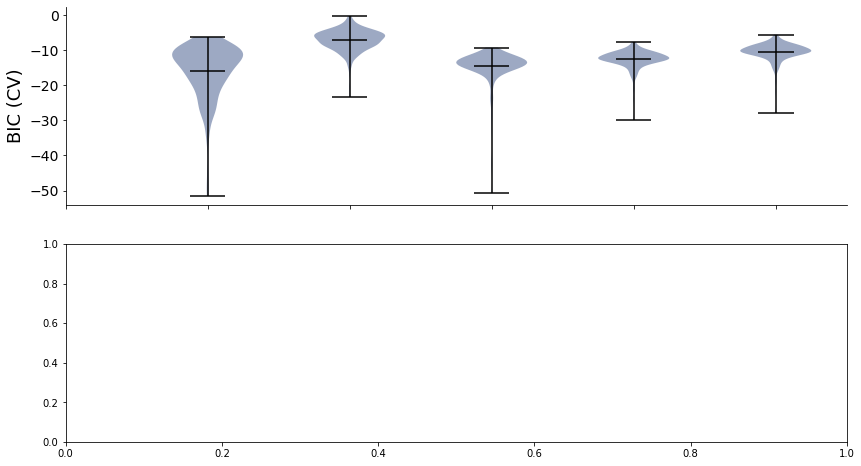

In [9]:
fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (14,8))

varnames = ['CV', 'HWHH']
stat_list = []
for i,varname in enumerate(varnames) : 
    dico = make_new_dico()
    data = get_data(method_list, varname = varname, cluster_list = cluster_list, grouping_path = grouping_path)
    plot_diffs(dico, method_list, varname, axs[i], do_label = True if i == 1 else False)
    
    ks, kpval, dunn = compute_stats(dico, method_list, criterion = 'bic')
    stat_list.append([varname, ks, kpval, dunn])
    
fig.savefig('./output/sup_2_BIC.pdf', bbox_inches='tight', dpi=200, transparent=True)

plt.show()

In [10]:
for i, _ in enumerate(stat_list) :
    print('Variable %s' % stat_list[i][0])
    print('Kruskal value %.3f, pval %.12f' % (stat_list[i][1], stat_list[i][2]))
    print('Dunn Posthoc :')
    print(stat_list[i][-1])
    print('-------------------\n\n')

In [11]:
stat_list[0]

IndexError: list index out of range